Searching for compositions with 1 peak(s)...
✓ Found perfect composition at sample 2!
✓ Found perfect composition at sample 3!
✓ Found perfect composition at sample 4!
✓ Found perfect composition at sample 5!
✓ Found perfect composition at sample 6!
✓ Found perfect composition at sample 7!
✓ Found perfect composition at sample 8!
✓ Found perfect composition at sample 9!
✓ Found perfect composition at sample 10!
✓ Found perfect composition at sample 12!
✓ Found perfect composition at sample 14!
✓ Found perfect composition at sample 15!
✓ Found perfect composition at sample 16!
✓ Found perfect composition at sample 17!
✓ Found perfect composition at sample 18!
✓ Found perfect composition at sample 19!
✓ Found perfect composition at sample 20!
✓ Found perfect composition at sample 21!
✓ Found perfect composition at sample 22!
✓ Found perfect composition at sample 23!
✓ Found perfect composition at sample 24!
✓ Found perfect composition at sample 25!
✓ Found perfect composition at sample 2

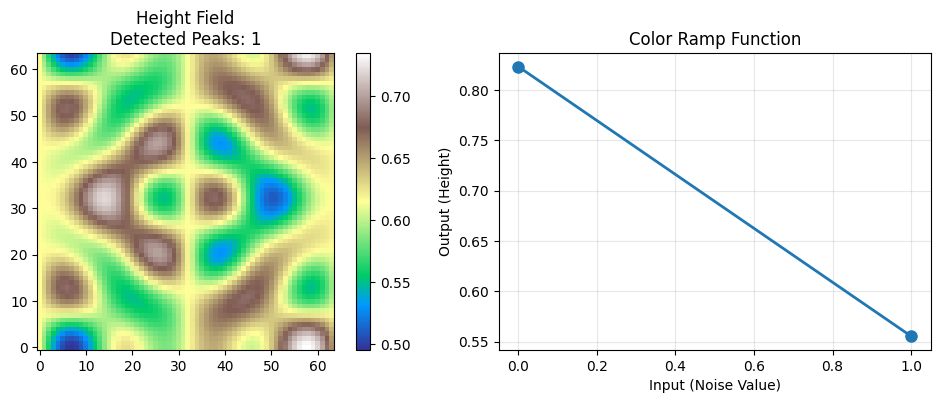

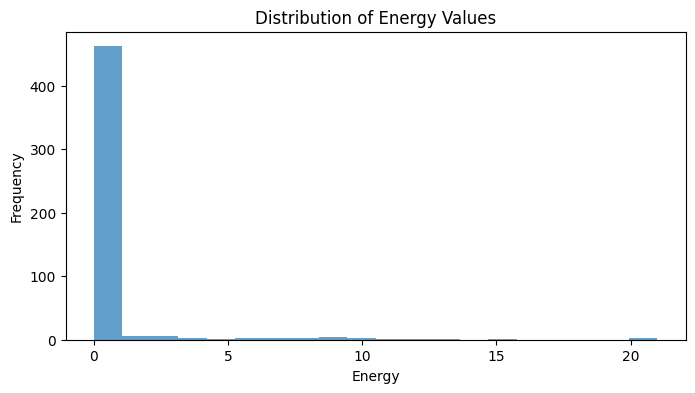

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import random

@dataclass
class ColorRampPoint:
    """A single control point in the color ramp"""
    position: float  # 0.0 to 1.0
    value: float     # height multiplier

@dataclass 
class GeometryComposition:
    """Represents a complete geometry node composition"""
    noise_scale: float
    color_ramp_points: List[ColorRampPoint]
    position_strength: float

class PeakDetector:
    """Detects peaks/islands in the generated height field"""
    
    def __init__(self, grid_size=64, threshold=0.1):
        self.grid_size = grid_size
        self.threshold = threshold
    
    def generate_height_field(self, composition: GeometryComposition) -> np.ndarray:
        """Generate height field from composition"""
        # Create noise field
        x = np.linspace(0, composition.noise_scale, self.grid_size)
        y = np.linspace(0, composition.noise_scale, self.grid_size)
        X, Y = np.meshgrid(x, y)
        
        # Simple Perlin-like noise (using sine waves for simplicity)
        noise = (np.sin(X) * np.cos(Y) + 
                np.sin(2*X) * np.cos(3*Y) + 
                np.sin(3*X) * np.cos(2*Y)) / 3.0
        
        # Normalize to 0-1
        noise = (noise - noise.min()) / (noise.max() - noise.min())
        
        # Apply color ramp transformation
        height_field = self.apply_color_ramp(noise, composition.color_ramp_points)
        
        # Apply position strength
        height_field *= composition.position_strength
        
        return height_field
    
    def apply_color_ramp(self, noise_field: np.ndarray, ramp_points: List[ColorRampPoint]) -> np.ndarray:
        """Apply color ramp transformation to noise field"""
        # Sort points by position
        points = sorted(ramp_points, key=lambda p: p.position)
        
        result = np.zeros_like(noise_field)
        
        for i in range(len(noise_field)):
            for j in range(len(noise_field[0])):
                noise_val = noise_field[i, j]
                
                # Find interpolation range
                if noise_val <= points[0].position:
                    result[i, j] = points[0].value
                elif noise_val >= points[-1].position:
                    result[i, j] = points[-1].value
                else:
                    # Linear interpolation between points
                    for k in range(len(points) - 1):
                        if points[k].position <= noise_val <= points[k+1].position:
                            t = (noise_val - points[k].position) / (points[k+1].position - points[k].position)
                            result[i, j] = points[k].value + t * (points[k+1].value - points[k].value)
                            break
        
        return result
    
    def count_peaks(self, height_field: np.ndarray) -> int:
        """Count number of distinct peaks/islands"""
        # Threshold the height field
        binary = height_field > self.threshold
        
        # Connected component labeling (simple flood fill)
        visited = np.zeros_like(binary, dtype=bool)
        peak_count = 0
        
        for i in range(binary.shape[0]):
            for j in range(binary.shape[1]):
                if binary[i, j] and not visited[i, j]:
                    # Found a new island, flood fill it
                    self._flood_fill(binary, visited, i, j)
                    peak_count += 1
        
        return peak_count
    
    def _flood_fill(self, binary: np.ndarray, visited: np.ndarray, start_i: int, start_j: int):
        """Flood fill for connected component labeling"""
        stack = [(start_i, start_j)]
        
        while stack:
            i, j = stack.pop()
            if (i < 0 or i >= binary.shape[0] or 
                j < 0 or j >= binary.shape[1] or 
                visited[i, j] or not binary[i, j]):
                continue
            
            visited[i, j] = True
            
            # Add neighbors
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                stack.append((i + di, j + dj))

class SimpleGFlowNet:
    """Simplified GFlowNet for geometry composition generation"""
    
    def __init__(self, target_peaks: int = 1):
        self.target_peaks = target_peaks
        self.detector = PeakDetector()
        self.successful_compositions = []
    
    def energy_function(self, composition: GeometryComposition) -> float:
        """Energy function - lower is better"""
        height_field = self.detector.generate_height_field(composition)
        detected_peaks = self.detector.count_peaks(height_field)
        return abs(detected_peaks - self.target_peaks)
    
    def generate_random_composition(self) -> GeometryComposition:
        """Generate a random composition to start trajectory"""
        # Random noise scale
        noise_scale = random.uniform(1.0, 10.0)
        
        # Random color ramp points (2-4 points)
        num_points = random.randint(2, 4)
        positions = sorted([random.random() for _ in range(num_points)])
        positions[0] = 0.0  # Ensure start point
        positions[-1] = 1.0  # Ensure end point
        
        ramp_points = [ColorRampPoint(pos, random.uniform(0.0, 1.0)) 
                      for pos in positions]
        
        # Random position strength
        position_strength = random.uniform(0.1, 2.0)
        
        return GeometryComposition(noise_scale, ramp_points, position_strength)
    
    def run_experiment(self, num_samples: int = 1000) -> Tuple[List[GeometryComposition], List[float]]:
        """Run the experiment to find compositions with target peaks"""
        compositions = []
        energies = []
        
        print(f"Searching for compositions with {self.target_peaks} peak(s)...")
        
        for i in range(num_samples):
            composition = self.generate_random_composition()
            energy = self.energy_function(composition)
            
            compositions.append(composition)
            energies.append(energy)
            
            if energy == 0:
                print(f"✓ Found perfect composition at sample {i+1}!")
                self.successful_compositions.append(composition)
            
            if (i + 1) % 100 == 0:
                best_energy = min(energies)
                print(f"Sample {i+1}: Best energy so far = {best_energy}")
        
        return compositions, energies
    
    def visualize_composition(self, composition: GeometryComposition):
        """Visualize a composition's height field"""
        height_field = self.detector.generate_height_field(composition)
        detected_peaks = self.detector.count_peaks(height_field)
        
        plt.figure(figsize=(10, 4))
        
        # Height field
        plt.subplot(1, 2, 1)
        plt.imshow(height_field, cmap='terrain', origin='lower')
        plt.colorbar()
        plt.title(f'Height Field\nDetected Peaks: {detected_peaks}')
        
        # Color ramp visualization
        plt.subplot(1, 2, 2)
        positions = [p.position for p in composition.color_ramp_points]
        values = [p.value for p in composition.color_ramp_points]
        plt.plot(positions, values, 'o-', linewidth=2, markersize=8)
        plt.xlabel('Input (Noise Value)')
        plt.ylabel('Output (Height)')
        plt.title('Color Ramp Function')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Run the experiment
if __name__ == "__main__":
    # Create GFlowNet instance targeting 1 peak
    gfn = SimpleGFlowNet(target_peaks=1)
    
    # Run experiment
    compositions, energies = gfn.run_experiment(num_samples=500)
    
    # Show results
    print(f"\nResults:")
    print(f"Total samples: {len(compositions)}")
    print(f"Successful compositions (0 energy): {len(gfn.successful_compositions)}")
    print(f"Best energy achieved: {min(energies)}")
    
    # Visualize best composition
    best_idx = np.argmin(energies)
    best_composition = compositions[best_idx]
    print(f"\nVisualizing best composition (energy = {energies[best_idx]}):")
    gfn.visualize_composition(best_composition)
    
    # Energy distribution
    plt.figure(figsize=(8, 4))
    plt.hist(energies, bins=20, alpha=0.7)
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.title('Distribution of Energy Values')
    plt.show()

# 